# **이진 분류**

In [ ]:
import sys

 # 노트북이 코랩에서 실행 중인지 체크합니다.
if 'google.colab' in sys.modules:
    !echo 'debconf debconf/frontend select Noninteractive' | debconf-set-selections
    # 나눔 폰트를 설치합니다.
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)
    # 나눔바른고딕 폰트로 설정합니다.
    import matplotlib.pyplot as plt
    plt.rc('font', family='NanumBarunGothic')
   # 마이너스 기호 표시 오류 수정
    import matplotlib
    matplotlib.rcParams['axes.unicode_minus'] = False

Selecting previously unselected package fonts-nanum.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
# 기본 그래프 폰트 설정
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [ ]:
# 파일 다운로드
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame = False) # True시 pandas로 반환

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
X, y = mnist.data, mnist.target

#train_input, test_input, train_target, test_target
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
# 간단한 이진 분류 테스트
y_train_5 = (y_train == '5') # 불리언 인덱싱
y_test_5 = (y_test == '5')

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')
# 아무렇게나 예측해도 90% 가 나오므로, 정확도는 좋은 측정 지표가 아님.

In [ ]:
# 이때는 오차 행렬을 사용하는게 좋음(잘못 분류된 클래스 비율)
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

"""오차 행렬을 만드는 방법은 순수한 예측을 반환한 다음,
   타깃 클래스와 예측 클래스로 행렬을 만들면 됨.
"""
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)

In [ ]:
"""
오차 행렬외에 클래스 분류 점수를 보여주는 정밀도와 재현율 점수도 구현 가능
정밀도 : 양성으로 분류한 것 중에 진짜 양성 개수 (5,5,5,6) -> 75%
재현율 : 양성 샘플인데 음성으로 분류한 개수 (숫자가 5인데 5가 아니라고 분류한 것)

정밀도와 재현율은 trade-off 관계에 있다.
"""
from sklearn.metrics import precision_score, recall_score
print(f"정밀도 : {precision_score(y_train_5, y_train_pred)}")
print(f"재현율 : {recall_score(y_train_5, y_train_pred)}")

"""
그리고 이 두가지 점수를 하나로 합친(조화 평균) F1 점수
두 점수가 비슷할수록 f1 점수는 높은데, 이게 높다고 항상 바람직한건 아니다
상황에 따라 정밀도가 더 요구될 수도, 재현율이 더 요구될 수도 있기 때문이다.
"""
from sklearn.metrics import f1_score
print(f"F1 Score : {f1_score(y_train_5, y_train_pred)}")

"""
SGDClassifier는 자신이 결정한 어떤 임곗값을 기준으로 음성,양성으로 나눈다.
이 임곗값을 지정할 순 없지만, 몇을 사용했는지는 알 수 있다.
"""
y_scores = sgd_clf.decision_function([X[0]])
print(f"결정 점수 : {y_scores}")

In [ ]:
"""
적절한 임곗값이 얼마쯤일지 확인해볼 수 있을까?
"""
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# 모든 샘플의 결정 점수 반환
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3,
                             method = 'decision_function')

# 모든 임곗값에 대한 정밀도, 재현율 반환
threshold = 3000 # 임곗값
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
# 기다란 넘파이 배열 반환

In [ ]:
#그래프로 그려보기
plt.figure(figsize=(8, 4))  # 추가 코드
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# 추가 코드 –
idx = (thresholds >= threshold).argmax()  # 첫 번째 index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

In [ ]:
# 정밀도 / 재현율 곡선
# 재현율 80% 지점부터 급격하게 하락함, 따라서 정밀도 80~85% 재현율 60~70% 정도로 선택하는것이 합리적
# 아래 코드처럼 정밀도 90%으로 만들면 재현율이 약 48%라서 불량함.
import matplotlib.patches as patches  # 추가 코드 – 구부러진 화살표를 그리기 위해서

plt.figure(figsize=(6, 5))  # 추가 코드

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [ ]:
"""
정밀도/재현율 곡선 외에도 ROC(수신기 조작 특성)곡선을 활용할 수 있다
ROC곡선은 1 - 진짜 음성 비율TNR( = 거짓 양성 비율)의 곡선이다.
TNR을 특이도 라고도 하는데, 따라서 ROC곡선은 민감도(재현율)에 대한
1 - 특이도 곡선이라고 부를 수 있다.

ROC곡선과 정밀도/재현율 곡선(PR)곡선 중 어느것을 사용해야 할까?
양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 중요할때는 PR곡선
그 외에는 ROC 곡선을 사용한다.
"""
from sklearn.metrics import roc_curve

# 모든 샘플의 결정 점수 반환
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3,
                             method = 'decision_function')

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [ ]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # 추가 코드
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# 추가 코드
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

In [ ]:
"""
SGDClassifier말고 RandomForestClassifier도 사용해보자.
"""
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3,
                                    method = "predict_proba")

y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

In [ ]:
plt.figure(figsize=(6, 5))

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # 양성 확률 ≥ 50%
print(f1_score(y_train_5, y_train_pred_forest))
print(roc_auc_score(y_train_5, y_scores_forest))
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

# **다중분류**

In [ ]:
import sys

 # 노트북이 코랩에서 실행 중인지 체크합니다.
if 'google.colab' in sys.modules:
    !echo 'debconf debconf/frontend select Noninteractive' | debconf-set-selections
    # 나눔 폰트를 설치합니다.
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)
    # 나눔바른고딕 폰트로 설정합니다.
    import matplotlib.pyplot as plt
    plt.rc('font', family='NanumBarunGothic')
   # 마이너스 기호 표시 오류 수정
    import matplotlib
    matplotlib.rcParams['axes.unicode_minus'] = False

In [ ]:
# 파일 다운로드
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame = False) # True시 pandas로 반환

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
X, y = mnist.data, mnist.target

#train_input, test_input, train_target, test_target
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
"""
LogisiticRegressor, RandomforestClassifier 등 다중 레이블을 처리할 수 있는
모델도 있지만 SGDClassifier, SVC처럼 이진 분류만 수행 가능한 모델들도
여러겹으로 쌓아서 다중 분류를 시행할 수 있음.
"""

from sklearn.svm import SVC

#SGDClassifier도 똑같이 하면 됨.
svm_clf = SVC(random_state = 42)
svm_clf.fit(X_train[:2000], y_train[:2000])
# 이렇게 하면 10개의 레이블에 대해 총 45번의 비교(OvO 전략)를 시행하고 출력함
some_digit_score = svm_clf.decision_function([X[0]])
some_digit_score.round(2)
"""
array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]]) 여기서 가장 숫자가 높은(9.3) 레이블 5가 제대로 선택됨.
물론 보통은 레이블 인덱스와 레이블 이름이 다르기 때문에
svm_clf.classes_ 로 9.3에 해당하는 레이블이 뭔지 확인해야함.
"""

In [ ]:
#OvO 전략이 아닌 OvR전략을 강제로 사용하도록 만들수도 있음
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state = 42))
ovr_clf.fit(X_train[:2000], y_train[:2000])
some_digit_score = ovr_clf.decision_function([X[0]])
some_digit_score.round(2)
"""
array([[-1.33, -1.79, -1.39, -0.94, -2.29,  0.81, -1.72, -1.21, -1.64,
        -1.79]])
"""

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(svm_clf, X_train, y_train, cv= 3, scoring = 'accuracy',
                n_jobs = -1)

array([0.977 , 0.9738, 0.9739])

In [ ]:
from sklearn.preprocessing import StandardScaler

#간단한 표준화처리로 성능을 올릴 수 있다.(svm는 큰 향상 없고 sgd는 5%정도 오름)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))
cross_val_score(svm_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy',
                n_jobs = -1)

array([0.9596, 0.9602, 0.961 ])

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

""" 오차행렬을 시각화 하는 방법
1. 우선 cross_val_predict로 연속적인 예측 데이터를 만듬"""
# 매우 오래 걸림 15
y_train_pred = cross_val_predict(svm_clf, X_train_scaled, y_train, cv = 3,
                                 n_jobs = -1)

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

In [ ]:
# 이렇게 하면 정규화되고 백분율로 변환한 오차행렬 표를 볼 수 있음.
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize ='True',values_format = ".0%")
plt.show()

In [ ]:
# 이렇게 하면 오류가 어디서 발생했는지 더욱 확실하게 보임
wrong_answer = (y_train_pred != y_train) #틀린 애들만 모으기
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight = wrong_answer
                                        normalize ='True',values_format = ".0%")

다중 레이블 분류

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] #다중 레이블 생성

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel) # 간단함.

In [ ]:
# 다중 레이블 분류기를 평가하는 방법
from sklearn.metrics import f1_score

y_train_knn_pred = cross_val_predict(knn_clf, X_train[:5000], y_multilabel[:5000], cv = 3)
f1_score(y_multilabel[:5000], y_train_knn_pred[:5000], average = 'macro')
# average를 'weightd'로 지정하면 각 레이블 개수에 따라 가중치를 부여해서
# 모든 레이블이 같은 가중치로 훈련받을 수 있게 한다.
# 범위 설정 안하면 약97.5% 정도.

In [ ]:
""" 그렇다면 다중레이블을 지원하지 않는 모델에서 다중레이블을 사용하려면 어떻게 할까?
ClassifierChain 클래스를 이용하면 된다. 첫 번째 레이블로 모델을 학습하고
그 값을 특성에 넣고 두 번째 레이블로 학습하고,,, 의 반복이다.
그래서 레이블의 순서를 어떻게 하냐에 따라 결과가 달라질 수 있으며
order = 'random'으로 이 문제를 해결한다.
설명 : https://bit.ly/3SmzOiL
"""
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv = 3, random_state = 42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

다중 출력 분류(multioutput classification)\
한 레이블이 다중 클래스가 될 수 있다.(사과는 과일이며, 음식이다)

In [ ]:
"""mnist 숫자에 잡음을 넣고 잡음을 제거하는 시스템
분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고
각 레이블은 여러 값을 가지니(0 ~ 255) 다중 출력 분류 시스템이라고 함."""
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
#원본 이미지가 타깃임
y_train_mod = X_train
y_test_mod = X_test

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

plt.subplot(121); plot_digit(X_test_mod[0]) # 훈련 세트
plt.subplot(122); plot_digit(y_test_mod[0]) # 실제 타겟
plt.show()

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]]) # 예상 타겟
plot_digit(clean_digit)
plt.show()

# **연습문제**

In [25]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame = False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [26]:
X, y = mnist.data, mnist.target

#train_input, test_input, train_target, test_target
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

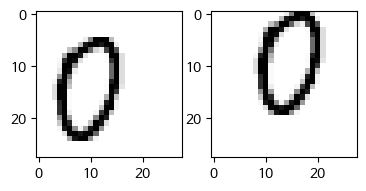

In [61]:
from scipy.ndimage import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dx, dy], cval = 0, mode = 'constant')
    return shifted_image.reshape([-1])

image = X_train[1000]
shift_left_image = shift_image(image, -5, 0)
shift_down_image = shift_image(image, 0, -5)

plt.subplot(131)
plt.imshow(shift_down_image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.imshow(shift_left_image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

In [62]:
X_train_augment = [image for image in X_train]
y_train_augment = [label for label in y_train]

for dx, dy in ((-1, 0), (0, -1), (1, 0), (0, 1)):
    for image, label in zip(X_train, y_train): #image,label을 한번에 불러오려고.
        X_train_augment.append(shift_image(image, dx, dy)) # shift한 이미지
        y_train_augment.append(label) # target은 그대로여야함.

X_train_augment = np.array(X_train_augment)
y_train_augment = np.array(y_train_augment)

In [64]:
# 순서 섞기
shuffle_idx = np.random.permutation(len(X_train_augment))
X_train_augment = X_train_augment[shuffle_idx]
y_train_augment = y_train_augment[shuffle_idx]

In [ ]:
 #훈련하기
knn_clf = KNeighborsClassifier(n_neighbors = 4, weights = 'distance')
knn_clf.fit(X_train_augment, y_train_augment)

In [66]:
#점수 매기기
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763

In [ ]:
""" 정확도는 큰 차이가 없으나 오류율은 크게 줄음
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)

error_rate_change = (1 - augmented_accuracy) / (1 - tuned_accuracy) - 1
print(f"error_rate_change = {error_rate_change:.0%}")
"""